# Aprendizado por Transferência (Transfer Learning)

## O que é Transfer Learning?

Transfer Learning, ou aprendizado por transferência, é uma técnica que permite reutilizar os padrões (também chamados de pesos) aprendidos por um modelo em um problema diferente.

Por exemplo, podemos aproveitar os padrões que um modelo de visão computacional aprendeu com grandes conjuntos de dados, como o ImageNet (com milhões de imagens de diferentes objetos), para aplicá-los em um novo modelo, como um classificador de alimentos.

Da mesma forma, um modelo de linguagem treinado com grandes quantidades de texto pode ser usado como base para classificação de textos em outra tarefa.

A ideia principal do Transfer Learning é encontrar um modelo já bem treinado e utilizá-lo para o seu próprio problema, reduzindo o tempo e os recursos necessários para treinar um modelo do zero.

---

## Exemplos de Transfer Learning

### 1. Visão Computacional (Computer Vision)
- Um modelo de visão computacional pode aprender padrões de imagens em um conjunto de dados massivo como o ImageNet.
- Depois, esses padrões podem ser utilizados para classificar imagens em um novo conjunto de dados, como fotos de comida.

### 2. Processamento de Linguagem Natural (NLP - Natural Language Processing)
- Um modelo de linguagem pode aprender a estrutura da linguagem ao ler toda a Wikipédia (e muito mais).
- Em seguida, ele pode aplicar esse conhecimento para tarefas como análise de sentimentos ou classificação de textos.

---

## Por que usar Transfer Learning?

Os dois principais benefícios do Transfer Learning são:

1. **Reutiliza um modelo existente**
   - Modelos pré-treinados já demonstraram bom desempenho em problemas similares.
   
2. **Economia de tempo e dados**
   - Um modelo que já aprendeu padrões similares pode gerar bons resultados com menos dados e menos tempo de treinamento.
  

> "Se conseguirmos melhorar o Transfer Learning, isso pode mudar o mundo. De repente, muito mais pessoas podem fazer trabalhos de alto nível com menos recursos e menos dados."

-----

##  Bibliotecas

In [2]:
import os
import zipfile
import requests
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from timeit import default_timer as timer
import random
from typing import List, Tuple
from PIL import Image

print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando dispositivo: {device}")

Torch version: 2.5.1
Torchvision version: 0.20.1
Usando dispositivo: cpu


## Obter Dados

In [3]:
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# baixar dados se não existirem
if image_path.is_dir():
    print(f"Diretório {image_path} já existe.")
else:
    print(f"Diretório {image_path} não encontrado, criando...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # baixar dados
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Baixando dados...")
        f.write(request.content)

    # extrair dados
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Extraindo dados...") 
        zip_ref.extractall(image_path)

    # remove arquivo zip
    os.remove(data_path / "pizza_steak_sushi.zip")

# configura diretórios
train_dir = image_path / "train"
test_dir = image_path / "test"

Diretório data\pizza_steak_sushi já existe.


## DataLoaders

Prepara a imagens para serem usadas pelo EfficietNet e organiza as imagens em batches para facilitar o treino e teste do modelo

In [4]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # pegando os pesos que o modelo aprendeu durante seu treino
auto_transforms = weights.transforms() # transformações automaticas nas imagens para deixar no formato que o modelo espera

# criação de DataLoaders
def create_dataloaders(train_dir: Path, 
                       test_dir: Path, 
                       transform: transforms.Compose, # transformacoes a serem aplicadas
                       batch_size: int): # numero de imagens por lote
    # cria datasets
    train_data = datasets.ImageFolder(root=train_dir, transform=transform)
    test_data = datasets.ImageFolder(root=test_dir, transform=transform)
    
    # obter nomes das classes
    class_names = train_data.classes
    
    train_dataloader = DataLoader(dataset=train_data, 
                                 batch_size=batch_size, # quantas imagens serao usadas por vez
                                 shuffle=True) # embaralha as imagens
    test_dataloader = DataLoader(dataset=test_data, 
                                batch_size=batch_size, 
                                shuffle=False)
    
    return train_dataloader, test_dataloader, class_names

train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transforms,
    batch_size=32
)

print(f"Nomes das classes: {class_names}")

Nomes das classes: ['pizza', 'steak', 'sushi']


## Obter modelo pré treinado

In [5]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

# congelar camadas base
for param in model.features.parameters():
    param.requires_grad = False # "nao mexer nos valores"

# ajusta a ultima camada
torch.manual_seed(42)
torch.cuda.manual_seed(42)
output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), # desativa aleatoriamente 20% dos neuronios para nao ter overfitting
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape,
                    bias=True)).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\BeatrizAlmeida/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:01<00:00, 20.6MB/s]


## Treinar Modelo

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# função de treino
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> dict:
    
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    
    for epoch in range(epochs):
        # treino
        model.train()
        train_loss, train_acc = 0, 0
        
        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            
            # forward pass
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # calcular acurácia
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_acc += (y_pred_class == y).sum().item()/len(y_pred)
        
        # calcular métricas de treino
        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)
        
        # teste
        model.eval()
        test_loss, test_acc = 0, 0
        with torch.inference_mode():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                test_pred = model(X)
                test_loss += loss_fn(test_pred, y).item()
                test_pred_labels = torch.argmax(torch.softmax(test_pred, dim=1), dim=1)
                test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)
        
        # calcular métricas de teste
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        
        # printar resultados
        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}")
        
        # salvar resultados
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    
    return results


In [7]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()

results = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5,
    device=device
)

end_time = timer()
print(f"Tempo total de treino: {end_time-start_time:.3f} segundos")

Epoch: 1 | train_loss: 1.0977 | train_acc: 0.3828 | test_loss: 0.8856 | test_acc: 0.6828
Epoch: 2 | train_loss: 0.9211 | train_acc: 0.6562 | test_loss: 0.7920 | test_acc: 0.8258
Epoch: 3 | train_loss: 0.7553 | train_acc: 0.8672 | test_loss: 0.6486 | test_acc: 0.9167
Epoch: 4 | train_loss: 0.7376 | train_acc: 0.7070 | test_loss: 0.5954 | test_acc: 0.8958
Epoch: 5 | train_loss: 0.6272 | train_acc: 0.7656 | test_loss: 0.6106 | test_acc: 0.8968
Tempo total de treino: 105.568 segundos


## Avaliar Modelo

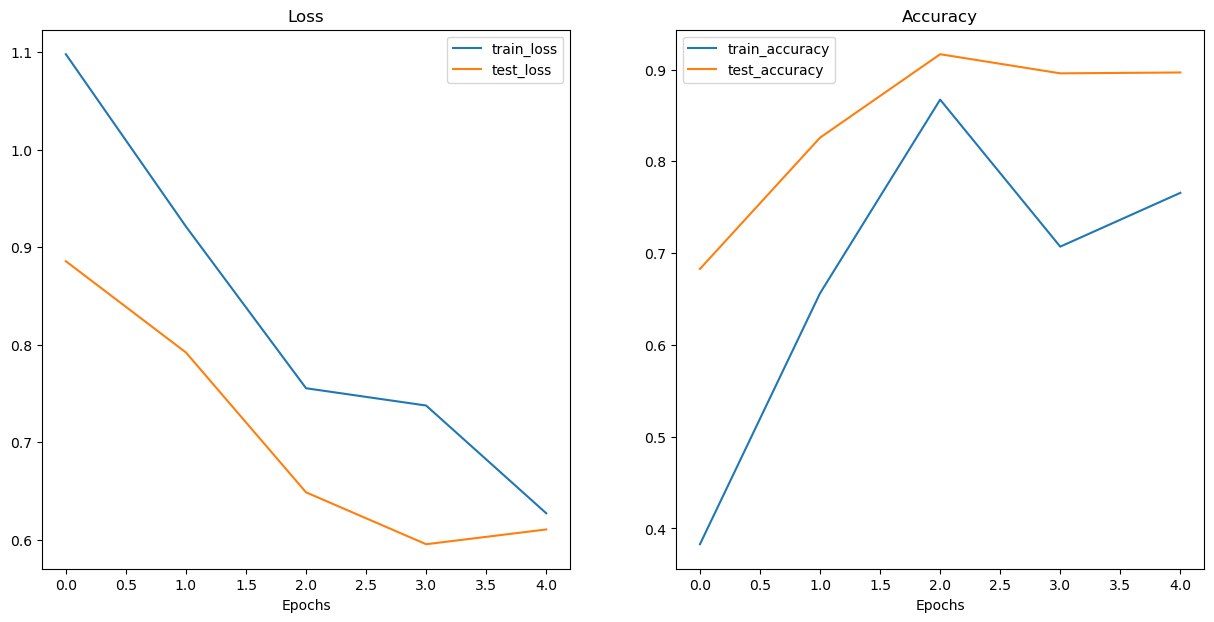

In [8]:
def plot_loss_curves(results: dict):
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]
    
    epochs = range(len(results["train_loss"]))
    
    plt.figure(figsize=(15, 7))
    
    # plotar loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    # plotar acurácia
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

plot_loss_curves(results)

## Previsões 

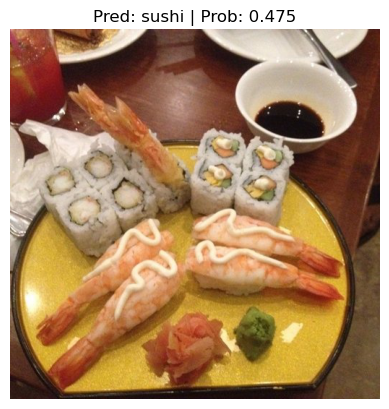

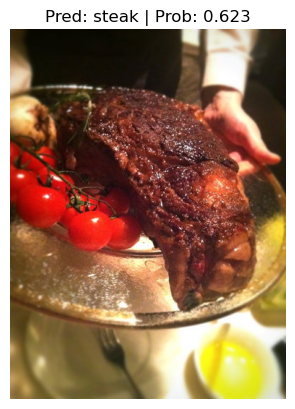

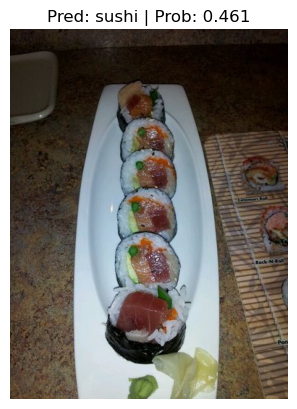

In [9]:
def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str, 
    class_names: List[str],
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device
):
    img = Image.open(image_path)
    
    # criar transformação se não for fornecida
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225]),
        ])
    
    # fazer previsão
    model.to(device)
    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0)
        target_image_pred = model(transformed_image.to(device))
    
    # converter previsões
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # plotar imagem
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)

# testar em imagens aleatórias do conjunto de teste
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list, k=num_images_to_plot)

for image_path in test_image_path_sample:
    pred_and_plot_image(
        model=model, 
        image_path=image_path,
        class_names=class_names
    )